# EARIN Lab 5 code implementation

## Importing libraries.

In [1]:
import torch
from torch import nn
from torch.optim import SGD
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(2)
torch.use_deterministic_algorithms(mode=True)
np.random.seed(2)
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


## Downloading and importing the dataset.

In [2]:
transform = transforms.Compose([transforms.Resize((28, 28)), transforms.ToTensor(), transforms.ConvertImageDtype(torch.float)])

from torchvision import datasets
train_dataset = datasets.FashionMNIST(root='./train_data', train=True, download=True, transform=transform)
val_dataset = datasets.FashionMNIST(root='./val_data', train=False, download=True, transform=transform)

inverse_encode_labels = [
    'T-shirt/top', 'Trousers', 'Pullover',
    'Dress', 'Coat', 'Sandal', 'Shirt',
    'Sneaker', 'Bag', 'Ankle boot'
    ]

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.5MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 201kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.70MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.5MB/s]
100%|██████████| 26.4M/26.4M [00:02<00:00, 11.2MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 202kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.70MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.8MB/s]


In [6]:
LR_1 = 1e-3
BATCH_1 = 16
EPOCHS = 20

In [7]:
train_loader = DataLoader(train_dataset, batch_size = BATCH_1, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_1, shuffle = True)

## Neural Network

In [8]:
class NetworkModel_1(nn.Module):
  def __init__(self, ini_hidden = 14, activation_func = nn.ReLU()):
    super().__init__()
    self.ini_hidden = ini_hidden

    self.conv1 = nn.Conv2d(1, self.ini_hidden, kernel_size = 3, padding=1)
    self.conv2 = nn.Conv2d(self.ini_hidden, 2*self.ini_hidden, kernel_size = 3, padding=1)

    self.pooling = nn.MaxPool2d(2, 2)

    self.activation_func = activation_func

    self.flatten = nn.Flatten()
    self.linear = nn.Linear((2*self.ini_hidden*7*7), self.ini_hidden)

    self.output = nn.Linear(self.ini_hidden, len(inverse_encode_labels))

  def forward(self, x):
                        # Outputs
    x = self.conv1(x)   # -> (14, 28, 28)
    x = self.activation_func(x)
    x = self.pooling(x) # -> (14, 14, 14)

    x = self.conv2(x)   # -> (28, 14, 14)
    x = self.activation_func(x)
    x = self.pooling(x) # -> (28, 7, 7)

    x = self.flatten(x) # -> (28 * 7 * 7)
    x = self.linear(x)  # -> 28
    x = self.output(x)  # -> 10
    return x

In [13]:
def train_loop(model, criterion, optimizer, train_loader, val_loader):
  total_loss_train_plot = []
  total_loss_val_plot = []
  total_loss_batch_plot = []
  total_acc_train_plot = []
  total_acc_val_plot = []

  for epoch in range(EPOCHS):
    total_loss_train = 0
    total_loss_val = 0
    total_acc_train = 0
    total_acc_val = 0

    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)

      # Forward pass
      predictions = model(images)
      train_loss = criterion(predictions, labels)
      total_loss_train += train_loss.item()
      total_loss_batch_plot.append(train_loss.item())

      train_acc = (torch.argmax(predictions, axis=1) == labels).sum().item()
      total_acc_train += train_acc

      # Backward pass
      optimizer.zero_grad()
      train_loss.backward()
      optimizer.step()

    with torch.no_grad():
      for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        predictions = model(images)
        val_loss = criterion(predictions, labels)
        total_loss_val += val_loss.item()

        val_acc = (torch.argmax(predictions, axis=1) == labels).sum().item()
        total_acc_val += val_acc

    total_loss_train_plot.append(round(total_loss_train / 1000, 4))
    total_acc_train_plot.append(round((total_acc_train / train_dataset.__len__()) * 100, 4))

    total_loss_val_plot.append(round(total_loss_val / 1000, 4))
    total_acc_val_plot.append(round((total_acc_val / val_dataset.__len__()) * 100, 4))

    print(f"""
    Epoch {epoch + 1}/{EPOCHS}
          Train Loss: {round(total_loss_train / 1000, 4)}
          Validation Loss: {round(total_loss_val / 1000, 4)}
          Train Accuracy: {round((total_acc_train / train_dataset.__len__()) * 100, 4)}
          Validation Accuracy: {round((total_acc_val / val_dataset.__len__()) * 100, 4)}
    """)
    print("="*40)

  return total_loss_train_plot, total_acc_train_plot, total_loss_val_plot, total_acc_val_plot, total_loss_batch_plot


In [15]:
def plot_train_val(total_loss_train_plot, total_loss_val_plot, total_acc_train_plot, total_acc_val_plot):
  fig, axis = plt.subplots(nrows = 1, ncols = 2, figsize=(15,5))

  axis[0].plot(total_loss_train_plot, label="Training Loss")
  axis[0].plot(total_loss_val_plot, label="Validation Loss")
  axis[0].set_title("Training and Validation Loss")
  axis[0].set_xlabel("Epochs")
  axis[0].set_ylabel("Loss")
  axis[0].legend()

  axis[1].plot(total_acc_train_plot, label="Training Accuracy")
  axis[1].plot(total_acc_val_plot, label="Validation Accuracy")
  axis[1].set_title("Training and Validation Accuracy")
  axis[1].set_xlabel("Epochs")
  axis[1].set_ylabel("Accuracy")
  axis[1].legend()

  plt.show()

In [22]:
def plot_batch_loss(total_loss_batch_plot):
  plt.figure(figsize=(15, 5))

  plt.plot(total_loss_batch_plot, label='Batch loss')
  plt.title('Batch loss for every learning step')
  plt.xlabel('Steps')
  plt.ylabel('Loss')

  plt.show()

## Experiments

### Experiment 1

In [10]:
model_1 = NetworkModel_1().to(device)

In [11]:
from torchsummary import summary
summary(model_1, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 14, 28, 28]             140
              ReLU-2           [-1, 14, 28, 28]               0
         MaxPool2d-3           [-1, 14, 14, 14]               0
            Conv2d-4           [-1, 28, 14, 14]           3,556
              ReLU-5           [-1, 28, 14, 14]               0
         MaxPool2d-6             [-1, 28, 7, 7]               0
           Flatten-7                 [-1, 1372]               0
            Linear-8                   [-1, 14]          19,222
            Linear-9                   [-1, 10]             150
Total params: 23,068
Trainable params: 23,068
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.29
Params size (MB): 0.09
Estimated Total Size (MB): 0.38
---------------------------------------------

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model_1.parameters(), lr = LR_1)

In [17]:
train_loss, train_acc, val_loss, val_acc, batch_loss = train_loop(model_1, criterion, optimizer, train_loader, val_loader)


    Epoch 1/20
          Train Loss: 5.8336
          Validation Loss: 0.5373
          Train Accuracy: 45.4083
          Validation Accuracy: 68.92
    

    Epoch 2/20
          Train Loss: 2.7858
          Validation Loss: 0.4302
          Train Accuracy: 73.1417
          Validation Accuracy: 75.03
    

    Epoch 3/20
          Train Loss: 2.4134
          Validation Loss: 0.393
          Train Accuracy: 76.6567
          Validation Accuracy: 77.36
    

    Epoch 4/20
          Train Loss: 2.2564
          Validation Loss: 0.38
          Train Accuracy: 78.0367
          Validation Accuracy: 76.91
    

    Epoch 5/20
          Train Loss: 2.1578
          Validation Loss: 0.3832
          Train Accuracy: 78.935
          Validation Accuracy: 76.6
    

    Epoch 6/20
          Train Loss: 2.0754
          Validation Loss: 0.3516
          Train Accuracy: 79.8767
          Validation Accuracy: 79.62
    

    Epoch 7/20
          Train Loss: 2.0062
          Validation Loss: 0.3

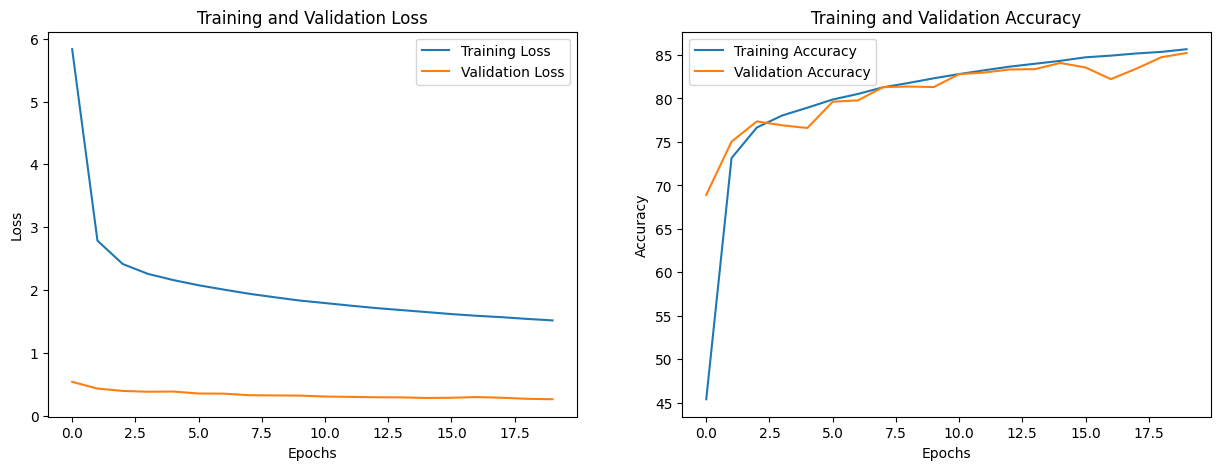

In [18]:
plot_train_val(train_loss, val_loss, train_acc, val_acc)

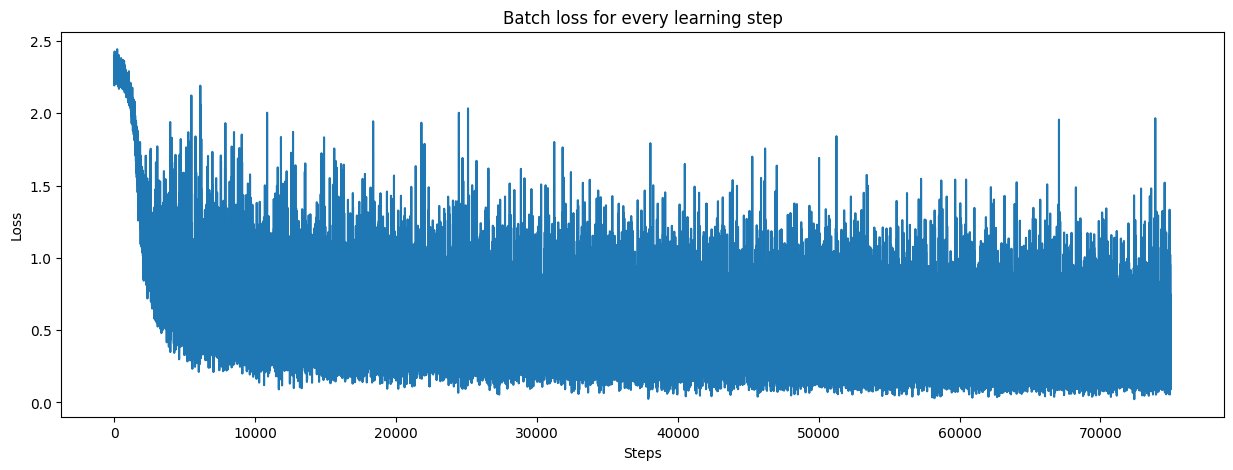

In [23]:
plot_batch_loss(batch_loss)

### Experiment 2

In [29]:
model_2 = NetworkModel_1().to(device)
optimizer_2 = SGD(model_2.parameters(), lr=0.01)
train_loss, train_acc, val_loss, val_acc, batch_loss = train_loop(model_2, criterion, optimizer_2, train_loader, val_loader)


    Epoch 1/20
          Train Loss: 2.818
          Validation Loss: 0.3641
          Train Accuracy: 72.4033
          Validation Accuracy: 78.96
    

    Epoch 2/20
          Train Loss: 1.8006
          Validation Loss: 0.2748
          Train Accuracy: 82.4817
          Validation Accuracy: 83.96
    

    Epoch 3/20
          Train Loss: 1.5062
          Validation Loss: 0.2489
          Train Accuracy: 85.51
          Validation Accuracy: 85.66
    

    Epoch 4/20
          Train Loss: 1.3564
          Validation Loss: 0.2248
          Train Accuracy: 87.0317
          Validation Accuracy: 87.46
    

    Epoch 5/20
          Train Loss: 1.2598
          Validation Loss: 0.2144
          Train Accuracy: 87.9817
          Validation Accuracy: 88.06
    

    Epoch 6/20
          Train Loss: 1.195
          Validation Loss: 0.2109
          Train Accuracy: 88.5817
          Validation Accuracy: 87.84
    

    Epoch 7/20
          Train Loss: 1.1429
          Validation Loss: 0.

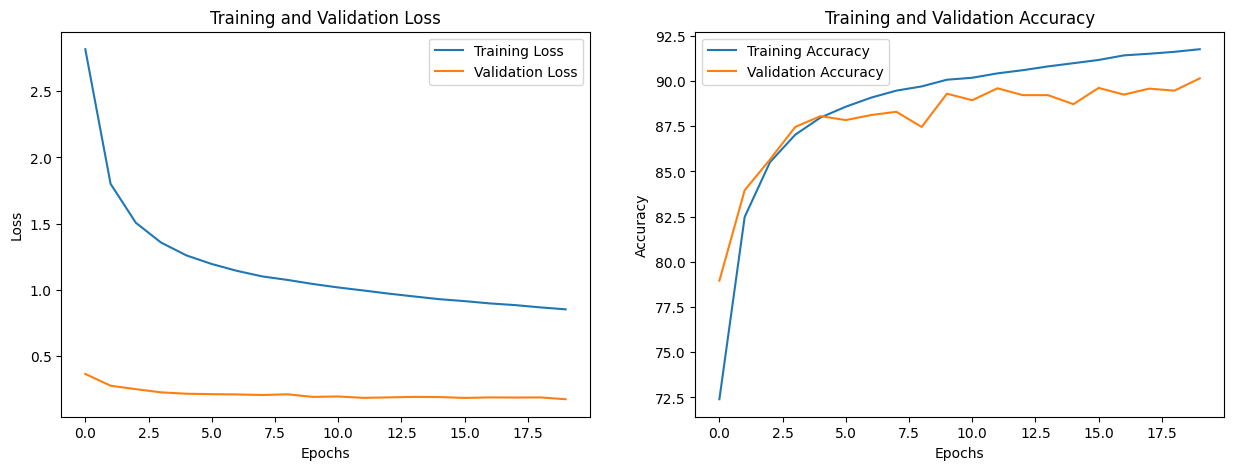

In [30]:
plot_train_val(train_loss, val_loss, train_acc, val_acc)

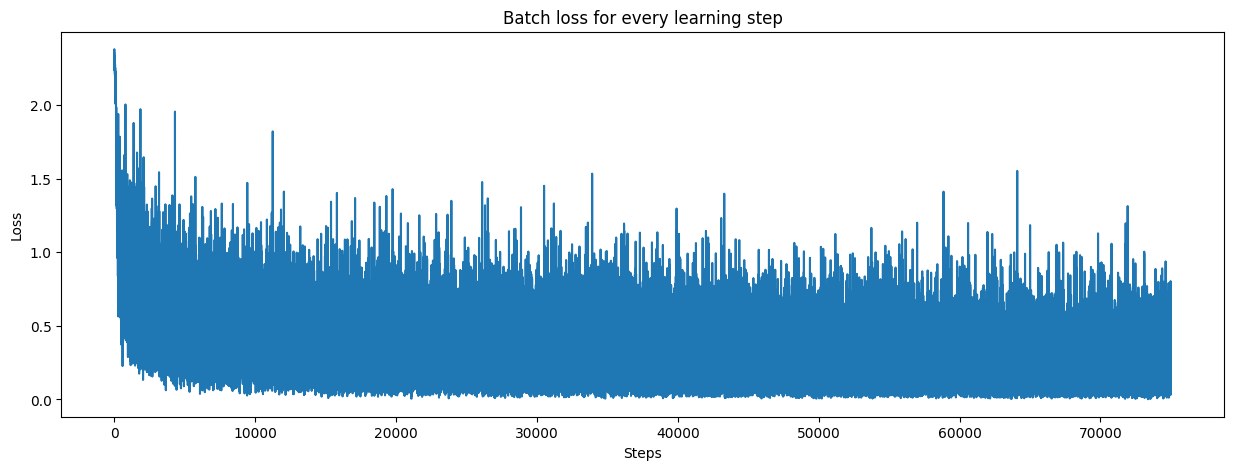

In [31]:
plot_batch_loss(batch_loss)

### Experiment 3

In [42]:
model_3 = NetworkModel_1().to(device)
optimizer_3 = SGD(model_3.parameters(), lr=0.0001)
train_loss, train_acc, val_loss, val_acc, batch_loss = train_loop(model_3, criterion, optimizer_3, train_loader, val_loader)


    Epoch 1/20
          Train Loss: 8.6238
          Validation Loss: 1.4251
          Train Accuracy: 11.03
          Validation Accuracy: 14.89
    

    Epoch 2/20
          Train Loss: 8.4592
          Validation Loss: 1.3919
          Train Accuracy: 18.5767
          Validation Accuracy: 23.37
    

    Epoch 3/20
          Train Loss: 8.1731
          Validation Loss: 1.3241
          Train Accuracy: 31.29
          Validation Accuracy: 34.77
    

    Epoch 4/20
          Train Loss: 7.5415
          Validation Loss: 1.1727
          Train Accuracy: 40.2617
          Validation Accuracy: 45.54
    

    Epoch 5/20
          Train Loss: 6.3203
          Validation Loss: 0.9307
          Train Accuracy: 47.8617
          Validation Accuracy: 51.69
    

    Epoch 6/20
          Train Loss: 4.9021
          Validation Loss: 0.7254
          Train Accuracy: 59.5733
          Validation Accuracy: 62.9
    

    Epoch 7/20
          Train Loss: 3.9526
          Validation Loss: 0.6

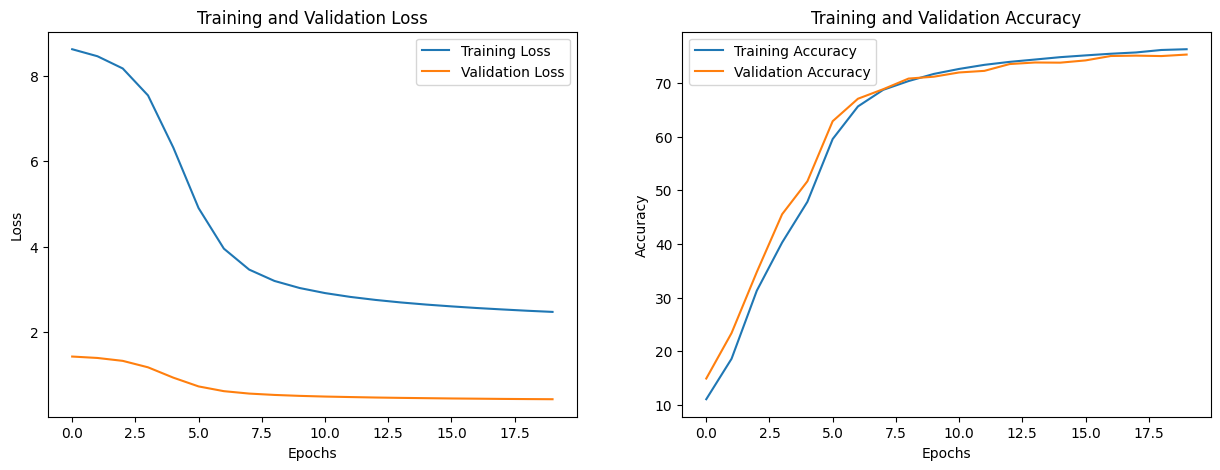

In [43]:
plot_train_val(train_loss, val_loss, train_acc, val_acc)

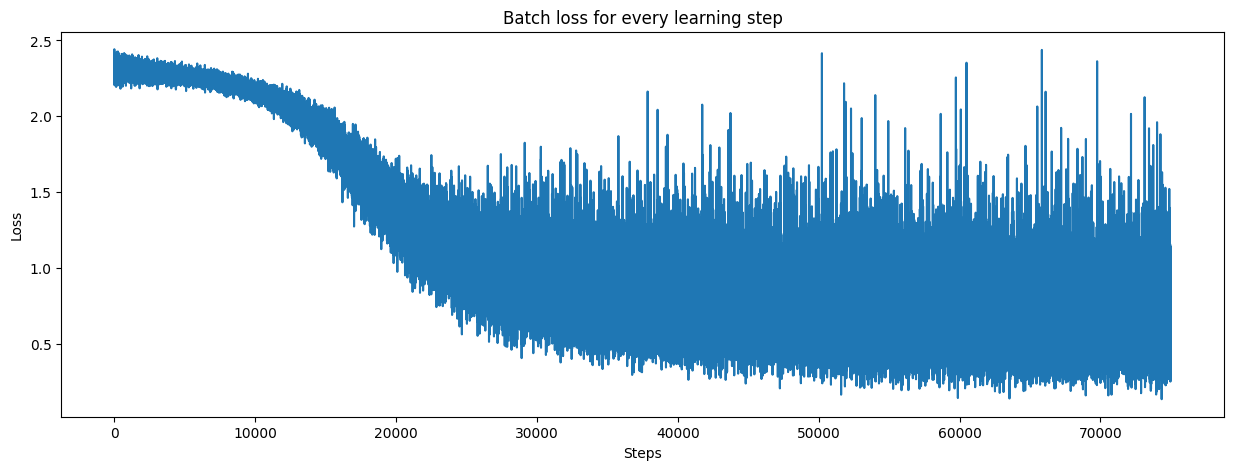

In [44]:
plot_batch_loss(batch_loss)

### Experiment 4

In [55]:
BATCH_SIZE = 1
train_loader_1 = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_loader_1 = DataLoader(val_dataset, batch_size=BATCH_SIZE)
model_4 = NetworkModel_1().to(device)
optimizer_4 = SGD(model_4.parameters(), lr=LR_1)
train_loss, train_acc, val_loss, val_acc, batch_loss = train_loop(model_4, criterion, optimizer_4, train_loader_1, val_loader_1)


    Epoch 1/20
          Train Loss: 41.2115
          Validation Loss: 4.7154
          Train Accuracy: 74.7667
          Validation Accuracy: 83.36
    

    Epoch 2/20
          Train Loss: 25.0724
          Validation Loss: 3.9373
          Train Accuracy: 84.9767
          Validation Accuracy: 86.17
    

    Epoch 3/20
          Train Loss: 21.5563
          Validation Loss: 3.5684
          Train Accuracy: 87.1867
          Validation Accuracy: 87.52
    

    Epoch 4/20
          Train Loss: 19.6345
          Validation Loss: 3.3449
          Train Accuracy: 88.3083
          Validation Accuracy: 88.27
    

    Epoch 5/20
          Train Loss: 18.3893
          Validation Loss: 3.2012
          Train Accuracy: 89.0417
          Validation Accuracy: 88.69
    

    Epoch 6/20
          Train Loss: 17.4894
          Validation Loss: 3.1041
          Train Accuracy: 89.575
          Validation Accuracy: 89.04
    

    Epoch 7/20
          Train Loss: 16.7641
          Validatio

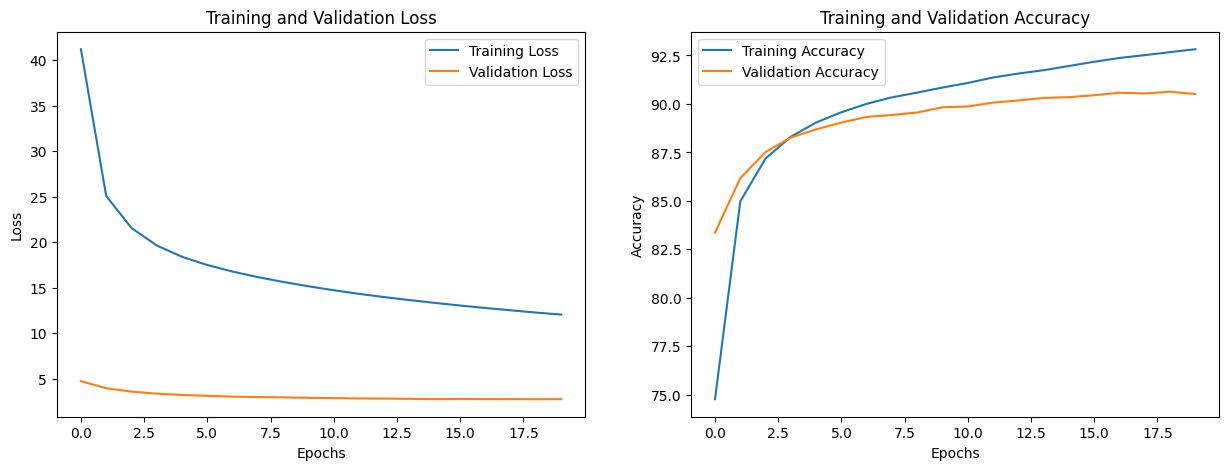

In [56]:
plot_train_val(train_loss, val_loss, train_acc, val_acc)

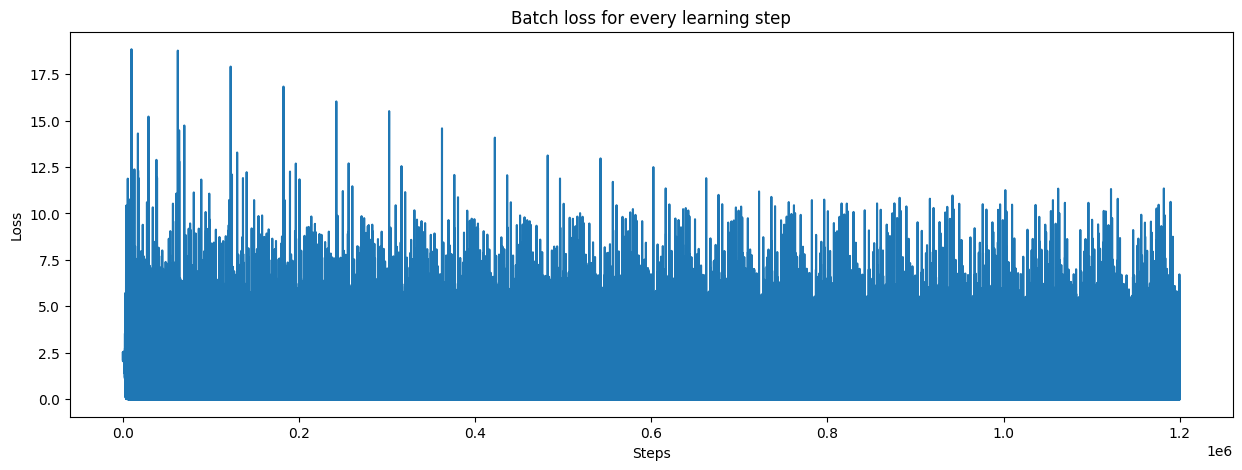

In [57]:
plot_batch_loss(batch_loss)

### Experiment 5

In [45]:
BATCH_SIZE = 64
train_loader_64 = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader_64 = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
model_5 = NetworkModel_1().to(device)
optimizer_5 = SGD(model_5.parameters(), lr=LR_1)
train_loss, train_acc, val_loss, val_acc, batch_loss = train_loop(model_5, criterion, optimizer_5, train_loader_64, val_loader_64)


    Epoch 1/20
          Train Loss: 2.1421
          Validation Loss: 0.352
          Train Accuracy: 12.43
          Validation Accuracy: 24.29
    

    Epoch 2/20
          Train Loss: 2.0035
          Validation Loss: 0.306
          Train Accuracy: 37.1367
          Validation Accuracy: 46.47
    

    Epoch 3/20
          Train Loss: 1.4396
          Validation Loss: 0.182
          Train Accuracy: 55.2817
          Validation Accuracy: 61.4
    

    Epoch 4/20
          Train Loss: 0.924
          Validation Loss: 0.1418
          Train Accuracy: 65.025
          Validation Accuracy: 67.45
    

    Epoch 5/20
          Train Loss: 0.7786
          Validation Loss: 0.1277
          Train Accuracy: 69.9683
          Validation Accuracy: 70.54
    

    Epoch 6/20
          Train Loss: 0.7142
          Validation Loss: 0.1185
          Train Accuracy: 72.7983
          Validation Accuracy: 71.89
    

    Epoch 7/20
          Train Loss: 0.6716
          Validation Loss: 0.1143

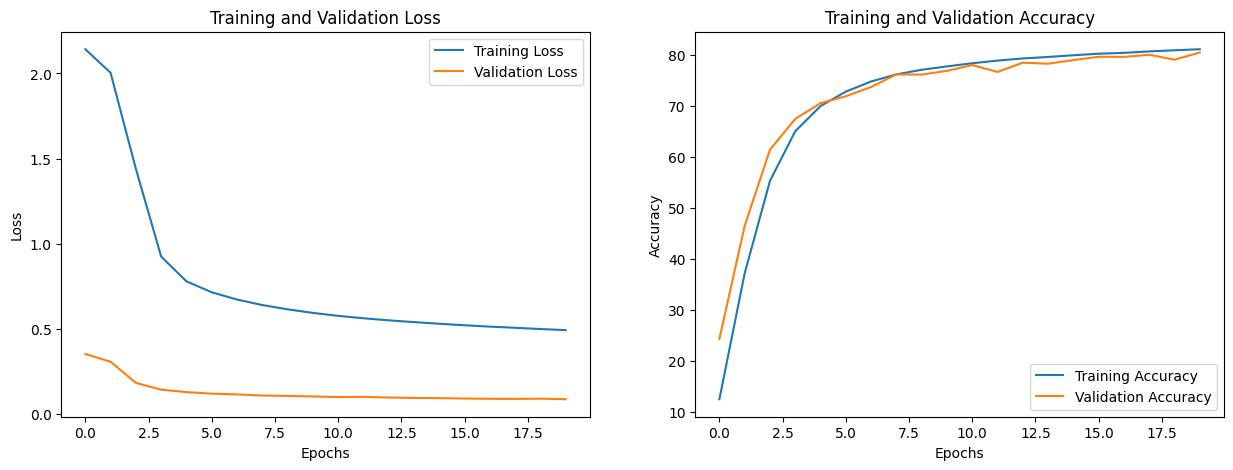

In [46]:
plot_train_val(train_loss, val_loss, train_acc, val_acc)

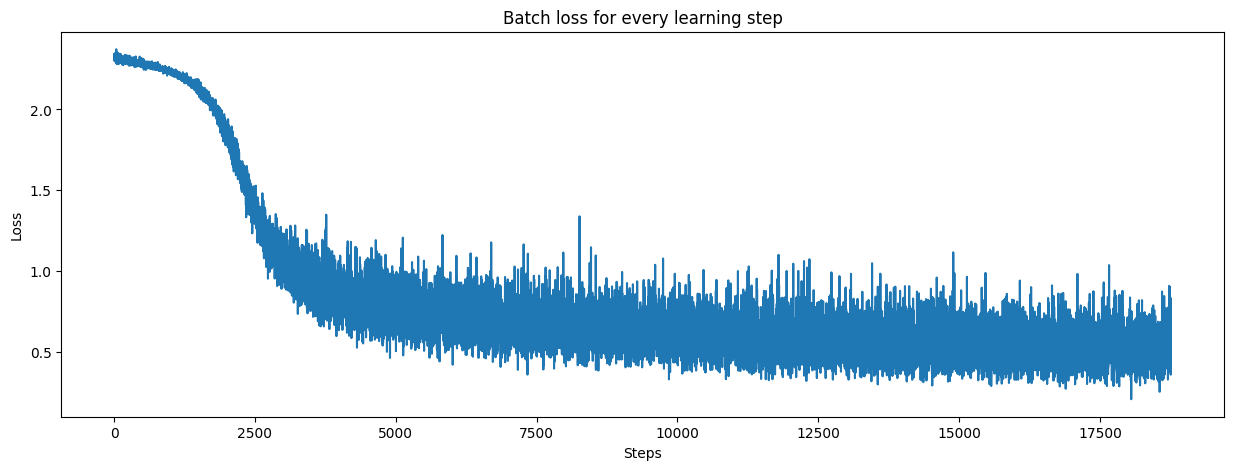

In [47]:
plot_batch_loss(batch_loss)

### Experiment 6

In [48]:
model_6 = NetworkModel_1(7).to(device)
optimizer_6 = SGD(model_6.parameters(), lr=LR_1)
train_loss, train_acc, val_loss, val_acc, batch_loss = train_loop(model_6, criterion, optimizer_6, train_loader, val_loader)


    Epoch 1/20
          Train Loss: 7.8383
          Validation Loss: 0.8061
          Train Accuracy: 22.5233
          Validation Accuracy: 51.81
    

    Epoch 2/20
          Train Loss: 3.2988
          Validation Loss: 0.4648
          Train Accuracy: 66.8133
          Validation Accuracy: 71.5
    

    Epoch 3/20
          Train Loss: 2.5658
          Validation Loss: 0.4164
          Train Accuracy: 74.3417
          Validation Accuracy: 74.73
    

    Epoch 4/20
          Train Loss: 2.3756
          Validation Loss: 0.3992
          Train Accuracy: 76.38
          Validation Accuracy: 76.09
    

    Epoch 5/20
          Train Loss: 2.259
          Validation Loss: 0.3817
          Train Accuracy: 77.555
          Validation Accuracy: 77.23
    

    Epoch 6/20
          Train Loss: 2.1699
          Validation Loss: 0.3724
          Train Accuracy: 78.5783
          Validation Accuracy: 78.28
    

    Epoch 7/20
          Train Loss: 2.0967
          Validation Loss: 0.3

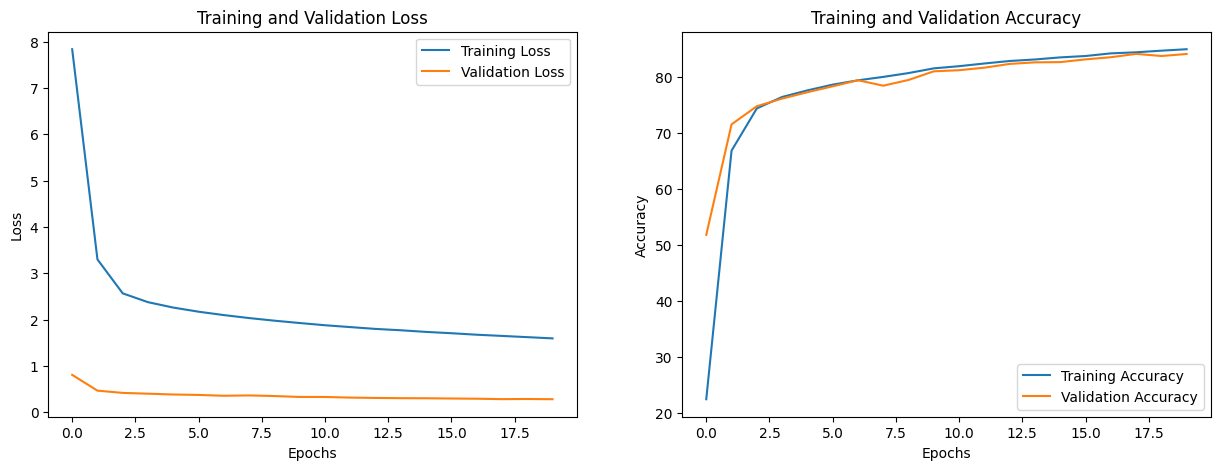

In [49]:
plot_train_val(train_loss, val_loss, train_acc, val_acc)

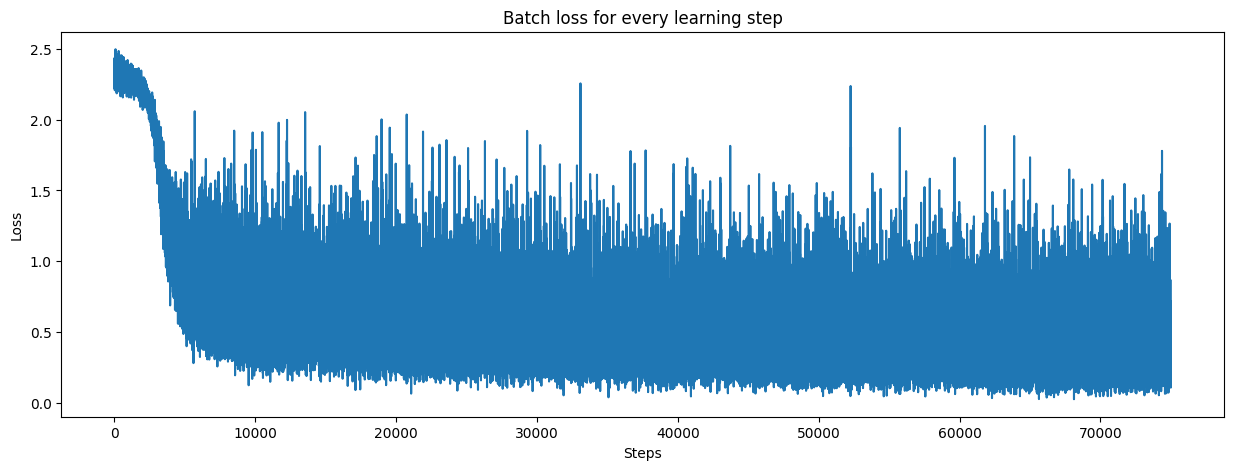

In [50]:
plot_batch_loss(batch_loss)

### Experiment 7

In [51]:
model_7 = NetworkModel_1(28).to(device)
optimizer_7 = SGD(model_7.parameters(), lr=LR_1)
train_loss, train_acc, val_loss, val_acc, batch_loss = train_loop(model_7, criterion, optimizer_7, train_loader, val_loader)


    Epoch 1/20
          Train Loss: 5.7396
          Validation Loss: 0.5195
          Train Accuracy: 48.905
          Validation Accuracy: 70.54
    

    Epoch 2/20
          Train Loss: 2.711
          Validation Loss: 0.4271
          Train Accuracy: 74.2767
          Validation Accuracy: 75.51
    

    Epoch 3/20
          Train Loss: 2.3952
          Validation Loss: 0.4011
          Train Accuracy: 76.9917
          Validation Accuracy: 76.29
    

    Epoch 4/20
          Train Loss: 2.255
          Validation Loss: 0.3863
          Train Accuracy: 78.115
          Validation Accuracy: 77.11
    

    Epoch 5/20
          Train Loss: 2.1547
          Validation Loss: 0.361
          Train Accuracy: 78.9417
          Validation Accuracy: 79.03
    

    Epoch 6/20
          Train Loss: 2.069
          Validation Loss: 0.3459
          Train Accuracy: 79.9617
          Validation Accuracy: 79.7
    

    Epoch 7/20
          Train Loss: 1.9843
          Validation Loss: 0.334

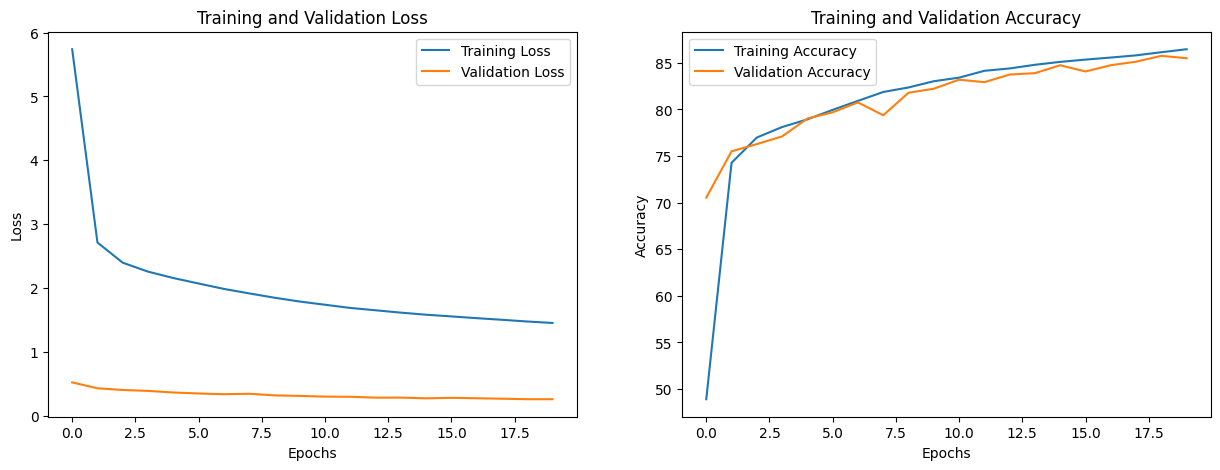

In [52]:
plot_train_val(train_loss, val_loss, train_acc, val_acc)

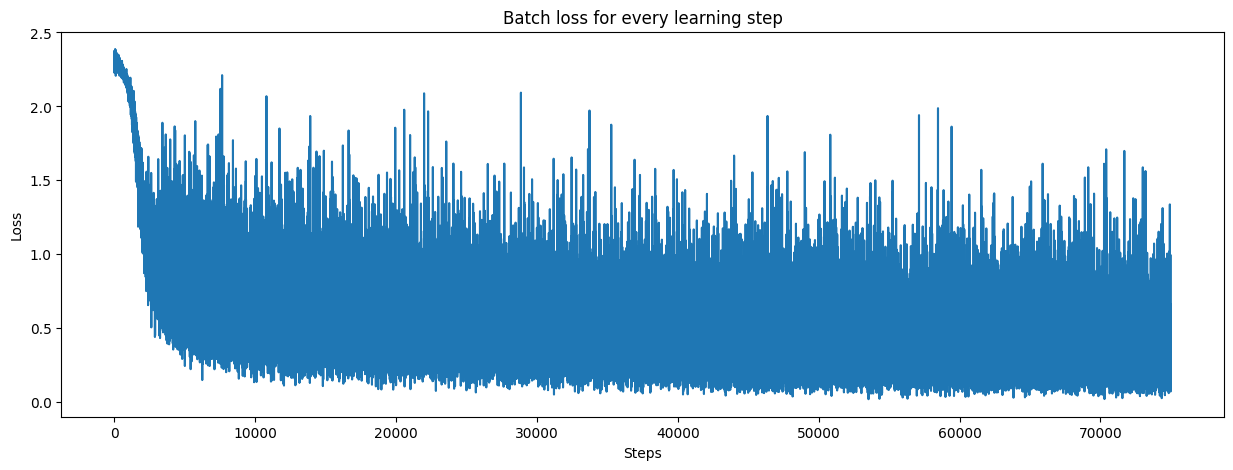

In [53]:
plot_batch_loss(batch_loss)

### Experiment 8

In [58]:
model_8 = NetworkModel_1(14, nn.Sigmoid()).to(device)
optimizer_8 = SGD(model_8.parameters(), lr=LR_1)
train_loss, train_acc, val_loss, val_acc, batch_loss = train_loop(model_8, criterion, optimizer_8, train_loader, val_loader)


    Epoch 1/20
          Train Loss: 8.6403
          Validation Loss: 1.4397
          Train Accuracy: 9.995
          Validation Accuracy: 10.0
    

    Epoch 2/20
          Train Loss: 8.6274
          Validation Loss: 1.4372
          Train Accuracy: 10.965
          Validation Accuracy: 10.0
    

    Epoch 3/20
          Train Loss: 8.6081
          Validation Loss: 1.4322
          Train Accuracy: 12.0033
          Validation Accuracy: 19.71
    

    Epoch 4/20
          Train Loss: 8.5725
          Validation Loss: 1.4234
          Train Accuracy: 14.8
          Validation Accuracy: 15.0
    

    Epoch 5/20
          Train Loss: 8.4738
          Validation Loss: 1.3963
          Train Accuracy: 20.4083
          Validation Accuracy: 17.38
    

    Epoch 6/20
          Train Loss: 8.074
          Validation Loss: 1.2636
          Train Accuracy: 29.3467
          Validation Accuracy: 38.43
    

    Epoch 7/20
          Train Loss: 6.6789
          Validation Loss: 0.9533
 

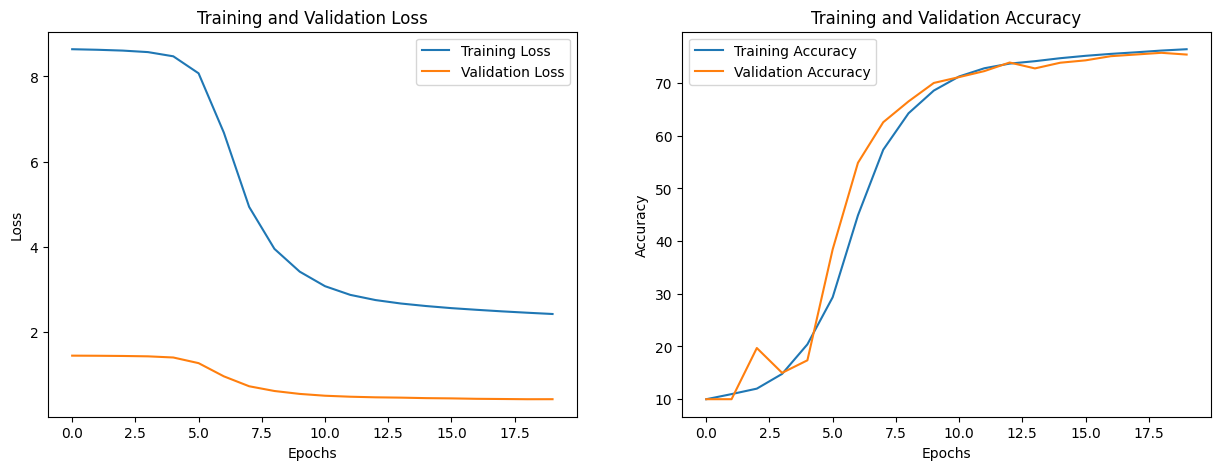

In [59]:
plot_train_val(train_loss, val_loss, train_acc, val_acc)

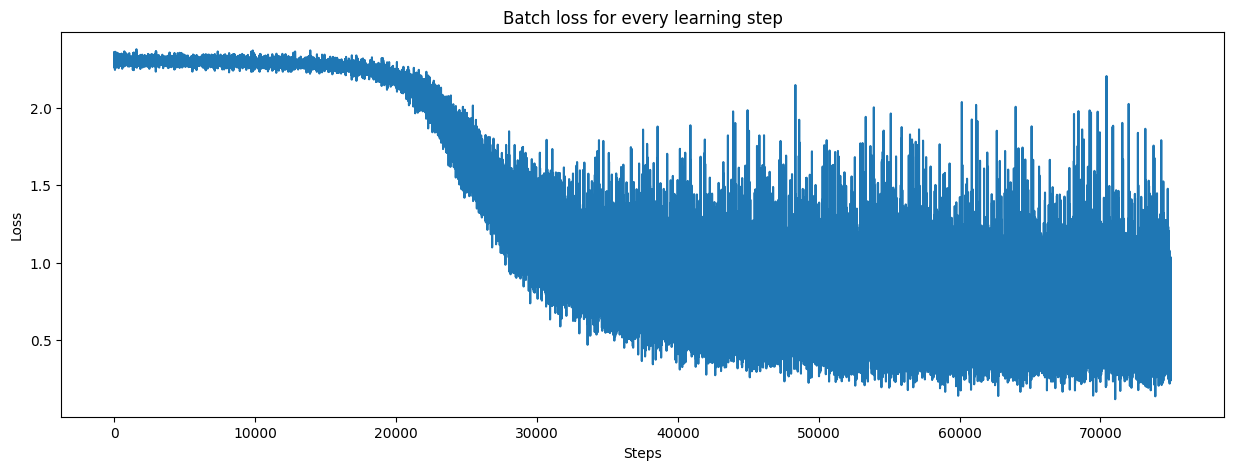

In [60]:
plot_batch_loss(batch_loss)

### Experiment 9

In [61]:
model_9 = NetworkModel_1(14, nn.GELU()).to(device)
optimizer_9 = SGD(model_9.parameters(), lr=LR_1)
train_loss, train_acc, val_loss, val_acc, batch_loss = train_loop(model_9, criterion, optimizer_9, train_loader, val_loader)


    Epoch 1/20
          Train Loss: 8.6328
          Validation Loss: 1.4284
          Train Accuracy: 12.63
          Validation Accuracy: 22.57
    

    Epoch 2/20
          Train Loss: 7.0183
          Validation Loss: 0.6126
          Train Accuracy: 40.2933
          Validation Accuracy: 64.7
    

    Epoch 3/20
          Train Loss: 3.0482
          Validation Loss: 0.4655
          Train Accuracy: 70.2
          Validation Accuracy: 73.08
    

    Epoch 4/20
          Train Loss: 2.5996
          Validation Loss: 0.4235
          Train Accuracy: 75.15
          Validation Accuracy: 75.98
    

    Epoch 5/20
          Train Loss: 2.4108
          Validation Loss: 0.401
          Train Accuracy: 76.9283
          Validation Accuracy: 76.88
    

    Epoch 6/20
          Train Loss: 2.288
          Validation Loss: 0.3844
          Train Accuracy: 78.1467
          Validation Accuracy: 78.1
    

    Epoch 7/20
          Train Loss: 2.1789
          Validation Loss: 0.3668
  

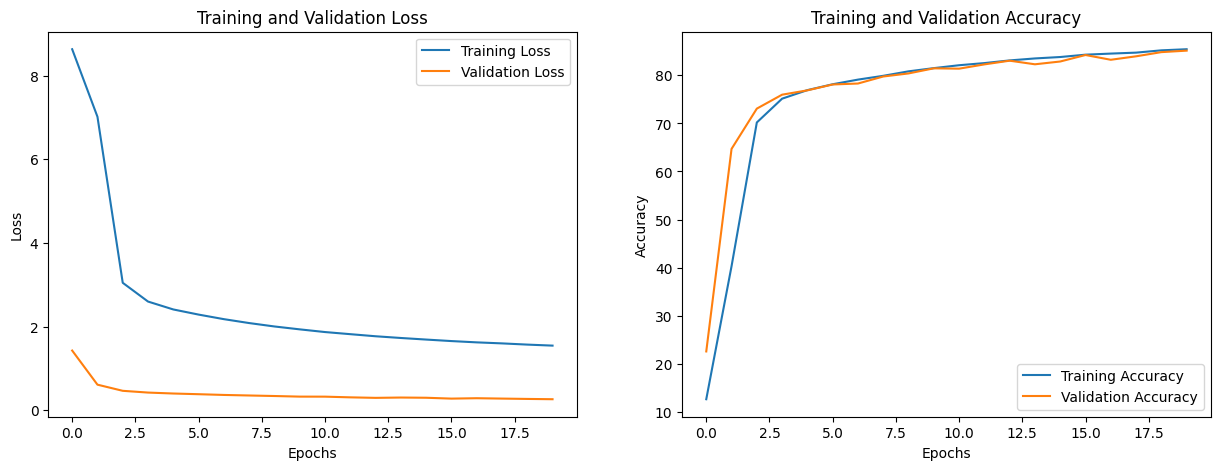

In [62]:
plot_train_val(train_loss, val_loss, train_acc, val_acc)

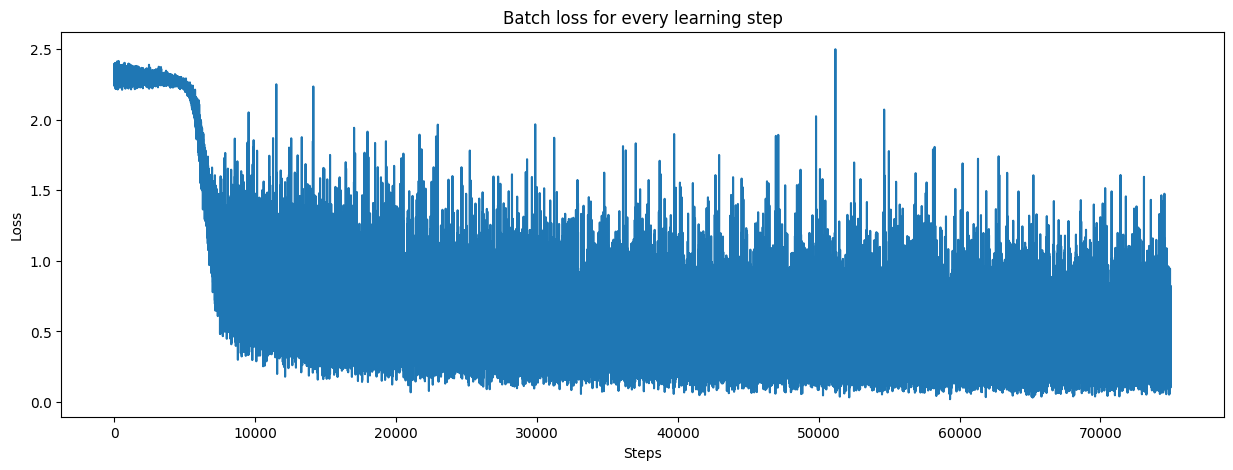

In [63]:
plot_batch_loss(batch_loss)

### Experiment 10

In [64]:
class NetworkModel_2(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 28, kernel_size = 3, padding=1)

    self.pooling = nn.MaxPool2d(2, 2)

    self.relu = nn.ReLU()

    self.flatten = nn.Flatten()
    self.linear1 = nn.Linear((28*14*14), 28)
    self.output = nn.Linear(28, len(inverse_encode_labels))

  def forward(self, x):
                        # Outputs
    x = self.conv1(x)   # -> (28, 28, 28)
    x = self.relu(x)
    x = self.pooling(x) # -> (28, 14, 14)

    x = self.flatten(x) # -> 28 * 14 * 14

    x = self.linear1(x) # -> 28
    x = self.output(x)  # -> 10
    return x

In [65]:
model_10 =  NetworkModel_2().to(device)
optimizer_10 = SGD(model_10.parameters(), lr=LR_1)
train_loss, train_acc, val_loss, val_acc, batch_loss = train_loop(model_10, criterion, optimizer_10, train_loader, val_loader)


    Epoch 1/20
          Train Loss: 4.1556
          Validation Loss: 0.4428
          Train Accuracy: 66.6283
          Validation Accuracy: 75.64
    

    Epoch 2/20
          Train Loss: 2.343
          Validation Loss: 0.375
          Train Accuracy: 78.1017
          Validation Accuracy: 78.73
    

    Epoch 3/20
          Train Loss: 2.0574
          Validation Loss: 0.347
          Train Accuracy: 80.5817
          Validation Accuracy: 79.89
    

    Epoch 4/20
          Train Loss: 1.9026
          Validation Loss: 0.3211
          Train Accuracy: 82.1333
          Validation Accuracy: 81.72
    

    Epoch 5/20
          Train Loss: 1.8058
          Validation Loss: 0.3114
          Train Accuracy: 83.135
          Validation Accuracy: 82.46
    

    Epoch 6/20
          Train Loss: 1.7354
          Validation Loss: 0.3004
          Train Accuracy: 83.745
          Validation Accuracy: 82.93
    

    Epoch 7/20
          Train Loss: 1.6863
          Validation Loss: 0.2

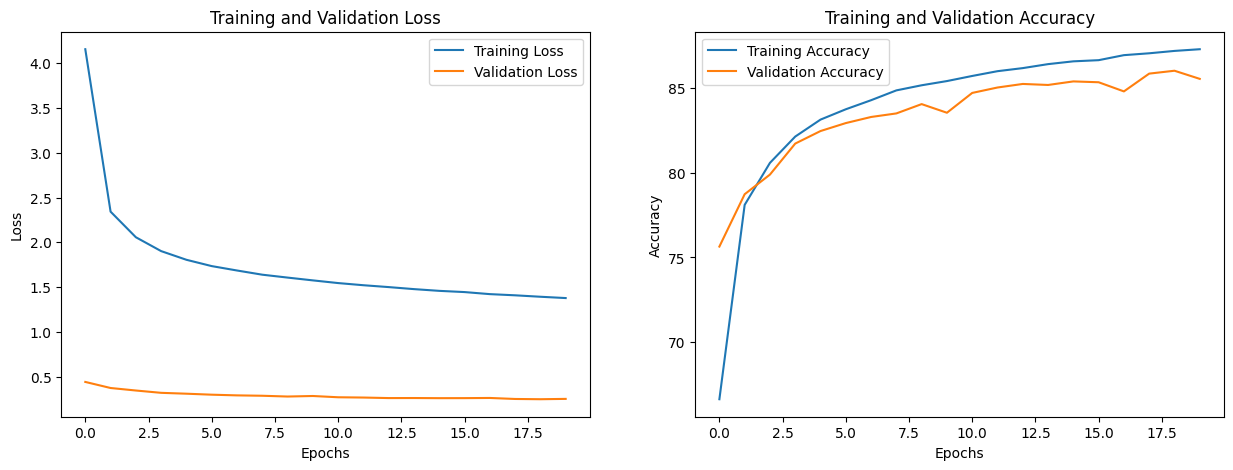

In [66]:
plot_train_val(train_loss, val_loss, train_acc, val_acc)

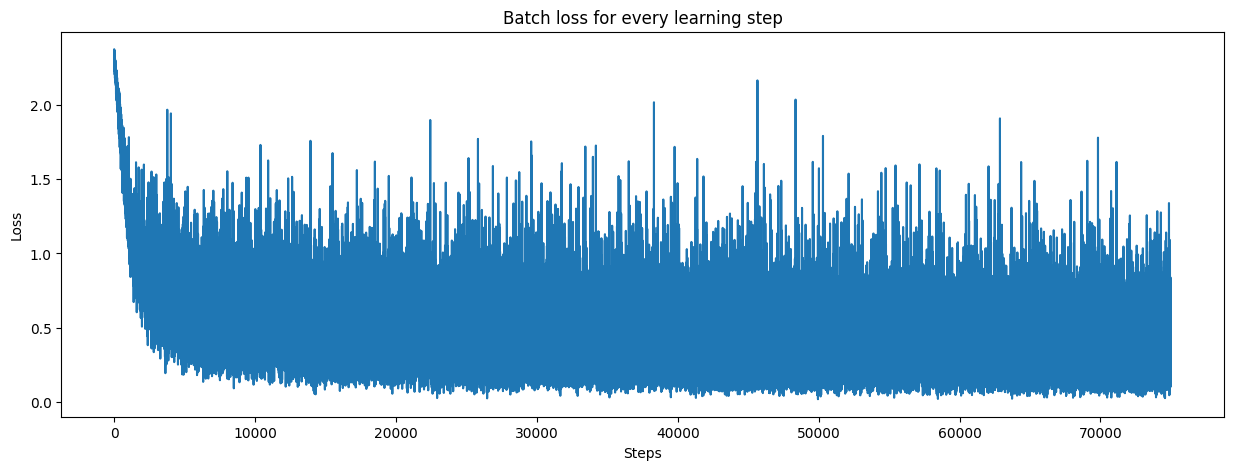

In [67]:
plot_batch_loss(batch_loss)

### Experiment 11

In [73]:
class NetworkModel_3(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.output = nn.Linear((1*28*28), len(inverse_encode_labels))

  def forward(self, x):
    x = self.flatten(x) # -> 1 * 28 * 28
    x = self.output(x)  # -> 10
    return x

In [74]:
model_11 =  NetworkModel_3().to(device)
optimizer_11 = SGD(model_11.parameters(), lr=LR_1)
train_loss, train_acc, val_loss, val_acc, batch_loss = train_loop(model_11, criterion, optimizer_11, train_loader, val_loader)


    Epoch 1/20
          Train Loss: 4.5506
          Validation Loss: 0.5702
          Train Accuracy: 65.7867
          Validation Accuracy: 70.75
    

    Epoch 2/20
          Train Loss: 3.0706
          Validation Loss: 0.4859
          Train Accuracy: 74.265
          Validation Accuracy: 74.54
    

    Epoch 3/20
          Train Loss: 2.7229
          Validation Loss: 0.4466
          Train Accuracy: 77.12
          Validation Accuracy: 76.31
    

    Epoch 4/20
          Train Loss: 2.5335
          Validation Loss: 0.4228
          Train Accuracy: 78.645
          Validation Accuracy: 77.89
    

    Epoch 5/20
          Train Loss: 2.4082
          Validation Loss: 0.4056
          Train Accuracy: 79.5883
          Validation Accuracy: 78.62
    

    Epoch 6/20
          Train Loss: 2.3165
          Validation Loss: 0.3933
          Train Accuracy: 80.2483
          Validation Accuracy: 79.32
    

    Epoch 7/20
          Train Loss: 2.2461
          Validation Loss: 0.

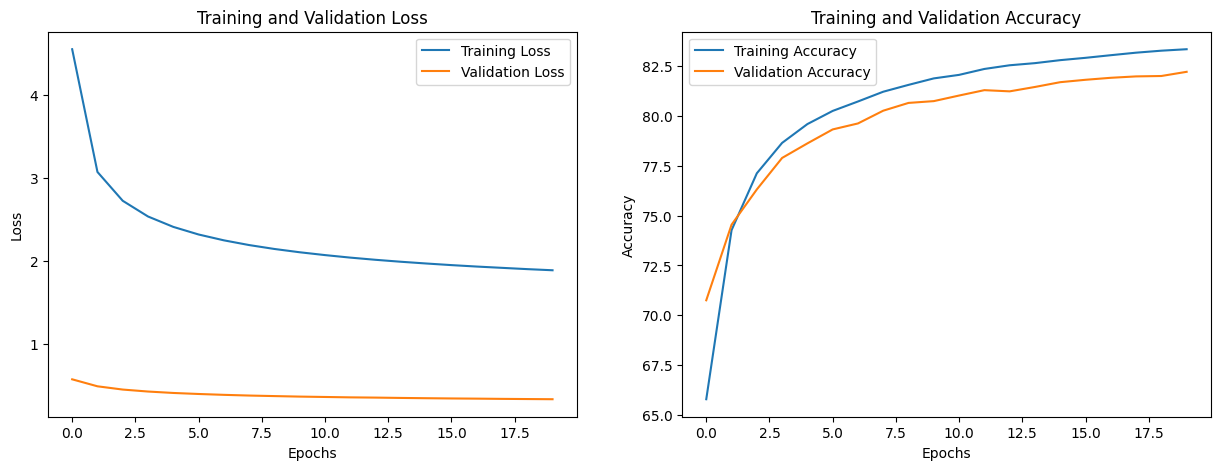

In [75]:
plot_train_val(train_loss, val_loss, train_acc, val_acc)

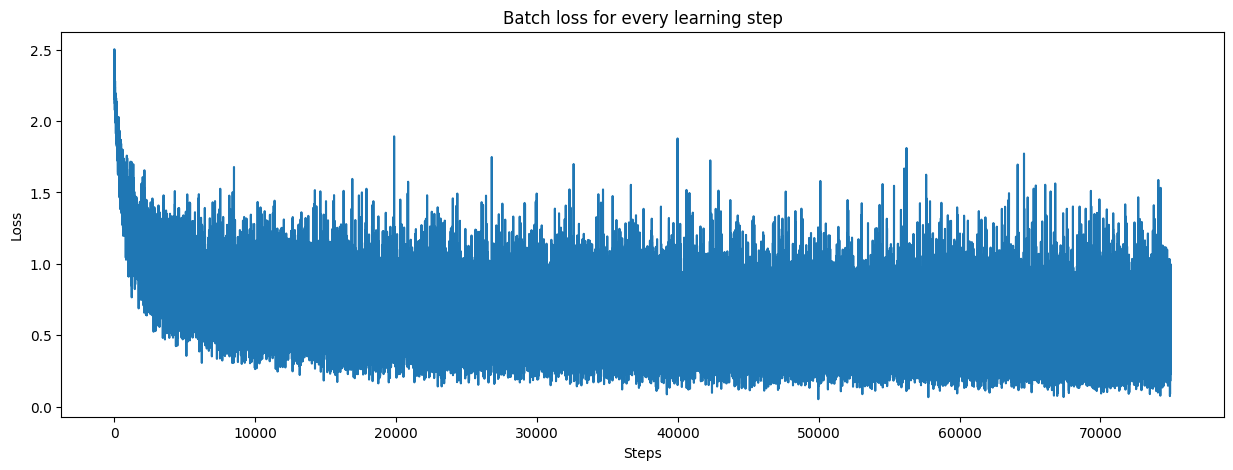

In [76]:
plot_batch_loss(batch_loss)